<a href="https://colab.research.google.com/github/matheusvazdata/ml-classificacao-analise-de-inadimplencia/blob/main/Projeto_ML_Coder_House_Classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 Projeto: Análise de Inadimplência e Comportamento Financeiro

## Objetivos Gerais

O objetivo central deste projeto é entender os fatores que levam à inadimplência de clientes e como esses fatores podem ser usados para prever quais clientes estão mais propensos a deixar de cumprir suas obrigações financeiras. A partir disso, busca-se criar um modelo de classificação que auxilie na tomada de decisões estratégicas, reduzindo riscos e aprimorando a gestão de crédito. Os objetivos específicos incluem:

1. **Analisar o Problema de Negócio**:  
   - Investigar os motivos por trás da inadimplência, explorando dados que podem influenciar essa decisão, como renda, tipo de cartão, histórico de transações, entre outros.  
   - Definir perguntas práticas, como: *Quais características tornam um cliente mais propenso a ficar inadimplente?* ou *O risco de inadimplência é maior em determinadas faixas etárias ou grupos de renda?*  

2. **Identificar Variáveis Relevantes**:  
   - Examinar a base de dados para identificar padrões entre clientes inadimplentes e adimplentes, priorizando variáveis que têm impacto direto no comportamento financeiro.  
   - Separar as variáveis explicativas e o alvo do modelo (*inadimplente* ou *não*), garantindo que os dados sejam adequados para o treinamento do modelo.  

3. **Planejar e Desenvolver o Modelo de Classificação**:  
   - Estruturar as etapas necessárias para a construção do modelo, desde a análise exploratória dos dados até o treinamento e validação de algoritmos de classificação.  
   - Garantir que o modelo forneça previsões acionáveis, permitindo instituições financeiras identificar padrões de risco e agir proativamente para mitigar futuros casos de inadimplência.

Esse planejamento visa transformar os dados financeiros da instituição em uma ferramenta preditiva poderosa, ajudando a criar estratégias baseadas em evidências para reduzir perdas e otimizar a concessão de crédito.

<img src='https://i.imgur.com/XmoIruU.jpeg' height=720><img>

## Data Acquisition

In [ ]:
# Instalar a biblioteca do Google Cloud
!pip install google-cloud-storage

In [ ]:
# Autenticar usuário no Google Cloud
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
from google.cloud import storage

# Definir variáveis do GCP
BUCKET_NAME = 'ml-classificacao-coder-house'
FOLDER_NAME = 'raw'
FILE_NAME = 'ds-default.csv'

# Criar cliente do Google Cloud Storage
client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(f'{FOLDER_NAME}/{FILE_NAME}')

# Fazer download do arquivo para o Colab
blob.download_to_filename(FILE_NAME)

In [ ]:
# Carregar dataset
df = pd.read_csv(FILE_NAME, sep=';')

# Exibir primeiras linhas para ver a estrutura
display(df.head())

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,768805383,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,"12.691,51","1.144,90",42
1,818770008,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,"8.256,96","1.291,45",33
2,713982108,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,"3.418,56","1.887,72",20
3,769911858,0,40,F,4,ensino medio,NaN,menos que $40K,blue,34,3,1,4,"3.313,03","1.171,56",20
4,709106358,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,"4.716,22","816,08",28


## Data Wrangling

In [ ]:
# Remover a coluna 'id', que não é necessária
df.drop(columns=['id'], inplace=True)

In [ ]:
# Converter colunas numéricas (corrigir separadores de milhar e decimal)
colunas_numericas = ['limite_credito', 'valor_transacoes_12m']
for coluna in colunas_numericas:
    df[coluna] = df[coluna].str.replace('.', '', regex=False)  # Remover pontos
    df[coluna] = df[coluna].str.replace(',', '.', regex=False)  # Substituir vírgulas por pontos
    df[coluna] = pd.to_numeric(df[coluna], errors='coerce')  # Converter para float, tratando erros

### Separação das Bases (Treino/Teste) Antes de Qualquer Transformação

In [ ]:
from sklearn.model_selection import train_test_split

def dividir_dados(df, target, test_size=0.2, random_state=2048):
    """
    Divide os dados em treino e teste ANTES de qualquer pré-processamento para evitar data leakage.

    Parâmetros:
    - df: DataFrame original.
    - target: Nome da variável alvo.
    - test_size: Proporção da base de teste (padrão: 20%).
    - random_state: Semente para reprodutibilidade.

    Retorna:
    - df_treino: Conjunto de treino.
    - df_teste: Conjunto de teste.
    """
    X = df.drop(columns=[target])
    y = df[target]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=test_size, random_state=random_state)

    df_treino = X_treino.copy()
    df_treino[target] = y_treino

    df_teste = X_teste.copy()
    df_teste[target] = y_teste

    return df_treino, df_teste

# Aplicar a separação corretamente
df_treino, df_teste = dividir_dados(df, target='default')  # Ajuste conforme sua variável alvo

In [ ]:
df_treino.head(2)

,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,default
1795,57,M,4,NaN,solteiro,$80K - $120K,blue,36,5,4,3,7558.56,3676.81,67,0
3536,63,M,1,ensino medio,solteiro,menos que $40K,blue,51,5,2,3,6102.92,4527.47,67,0


In [ ]:
# Verificar se há valores ausentes
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 1795 to 5957
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   idade                    8101 non-null   int64  
 1   sexo                     8101 non-null   object 
 2   dependentes              8101 non-null   int64  
 3   escolaridade             6871 non-null   object 
 4   estado_civil             7494 non-null   object 
 5   salario_anual            7211 non-null   object 
 6   tipo_cartao              8101 non-null   object 
 7   meses_de_relacionamento  8101 non-null   int64  
 8   qtd_produtos             8101 non-null   int64  
 9   iteracoes_12m            8101 non-null   int64  
 10  meses_inativo_12m        8101 non-null   int64  
 11  limite_credito           8101 non-null   float64
 12  valor_transacoes_12m     8101 non-null   float64
 13  qtd_transacoes_12m       8101 non-null   int64  
 14  default                  8

### Uma pausa para entender cada coluna
O conjunto de dados "Default Dataset" contém 10.127 registros e 15 variáveis que fornecem informações detalhadas sobre os clientes, abrangendo aspectos demográficos, comportamentais e financeiros. A seguir, uma descrição de cada variável:

1. ~**id (int)**: Identificador único do cliente~ (dropado anteriormente)

2. **default (int)**: Indica se o cliente entrou em inadimplência (0 = não, 1 = sim)

3. **idade (int)**: Idade do cliente.

4. **sexo (str)**: Gênero do cliente (M = masculino, F = feminino).

5. **dependentes (int)**: Quantidade de dependentes do cliente.

6. **escolaridade (str)**: Grau de escolaridade do cliente.

7. **estado_civil (str)**: Estado civil do cliente (casado, solteiro, etc.).

8. **salario_anual (str)**: Faixa salarial do cliente.

9. **tipo_cartao (str)**: Tipo de cartão de crédito utilizado pelo cliente.

10. **meses_de_relacionamento (int)**: Tempo, em meses, que o cliente tem relação com a instituição.

11. **qtd_produtos (int)**: Quantidade de produtos financeiros adquiridos pelo cliente.

12. **iteracoes_12m (int)**: Quantidade de interações do cliente com a instituição nos últimos 12 meses.

13. **meses_inativo_12m (int)**: Quantidade de meses em que o cliente esteve inativo nos últimos 12 meses.

14. **limite_credito (float)**: Limite de crédito do cliente.

15. **valor_transacoes_12m (float)**: Valor total das transações feitas pelo cliente nos últimos 12 meses.

16. **qtd_transacoes_12m (int)**: Quantidade de transações realizadas pelo cliente nos últimos 12 meses.

Essas variáveis fornecem uma visão abrangente sobre o perfil dos clientes e seus comportamentos financeiros, permitindo a análise de padrões que influenciam a inadimplência e a tomada de decisões estratégicas para gestão de crédito.

In [ ]:
# Exibir estatísticas do dataset após conversões
display(df_treino.describe().T)

,count,mean,std,min,25%,50%,75%,max
idade,8101.0,46.339588,8.012882,26.00,41.00,46.00,52.00,73.00
dependentes,8101.0,2.347982,1.298814,0.00,1.00,2.00,3.00,5.00
meses_de_relacionamento,8101.0,35.928404,7.982747,13.00,32.00,36.00,40.00,56.00
qtd_produtos,8101.0,3.814467,1.562056,1.00,3.00,4.00,5.00,6.00
iteracoes_12m,8101.0,2.451920,1.106017,0.00,2.00,2.00,3.00,6.00
meses_inativo_12m,8101.0,2.346377,1.010932,0.00,2.00,2.00,3.00,6.00
limite_credito,8101.0,8580.146831,9032.646828,1438.00,2542.11,4533.30,10973.05,34516.99
valor_transacoes_12m,8101.0,4402.887664,3412.128600,510.16,2146.18,3890.94,4741.47,18484.93
qtd_transacoes_12m,8101.0,64.716455,23.532845,10.00,45.00,67.00,80.00,139.00
default,8101.0,0.161585,0.368092,0.00,0.00,0.00,0.00,1.00


## Análise Exploratória de Dados

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### Criando uma função para rodar as distribuições das colunas desejadas

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plotar_distribuicao_agrupada(dados, coluna, agrupar_por='default', normalizar=False):
    """
    Gera boxplots horizontais e histogramas lado a lado para a coluna especificada,
    comparando grupos definidos pela variável `agrupar_por`.

    Parâmetros:
    - dados: DataFrame contendo os dados.
    - coluna: Nome da coluna para análise da distribuição.
    - agrupar_por: Nome da coluna que define os grupos (padrão: 'default').
    - normalizar: Se True, normaliza os histogramas para comparar distribuições.
    """
    if coluna not in dados.columns or agrupar_por not in dados.columns:
        print(f"Coluna '{coluna}' ou '{agrupar_por}' não existe no DataFrame.")
        return

    # Remover valores nulos da análise
    dados = dados[[coluna, agrupar_por]].dropna()

    # Determinar intervalos para os histogramas usando a regra de Sturges
    num_bins = int(np.ceil(1 + np.log2(len(dados[coluna]))))

    # Criar figuras
    figura, eixos = plt.subplots(2, 2, figsize=(14, 7), gridspec_kw={'height_ratios': [1, 3]})
    figura.suptitle(f"Distribuição de {coluna} por {agrupar_por}", fontsize=16)

    grupos = dados[agrupar_por].unique()
    cores = ['#1F77B4', '#CF809B']  # Azul e vermelho para melhor contraste

    for i, grupo in enumerate(grupos):
        dados_grupo = dados[dados[agrupar_por] == grupo]

        # Boxplot
        sns.boxplot(x=dados_grupo[coluna], ax=eixos[0, i], color=cores[i % len(cores)], orient='h')
        eixos[0, i].set_title(f"Boxplot ({grupo}, n={len(dados_grupo)})")
        eixos[0, i].set_xlabel("")
        eixos[0, i].tick_params(axis='x', labelbottom=False)

        # Histograma com normalização opcional
        sns.histplot(dados_grupo[coluna], kde=True, bins=num_bins, ax=eixos[1, i],
                     color=cores[i % len(cores)], stat='density' if normalizar else 'count')

        eixos[1, i].set_title(f"Histograma ({grupo}, n={len(dados_grupo)})")
        eixos[1, i].set_xlabel(coluna)
        eixos[1, i].set_ylabel("Densidade" if normalizar else "Frequência")

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    plt.show()

#### Histogramas agrupados por quem é adimplente (0) ou inadimplente (1)

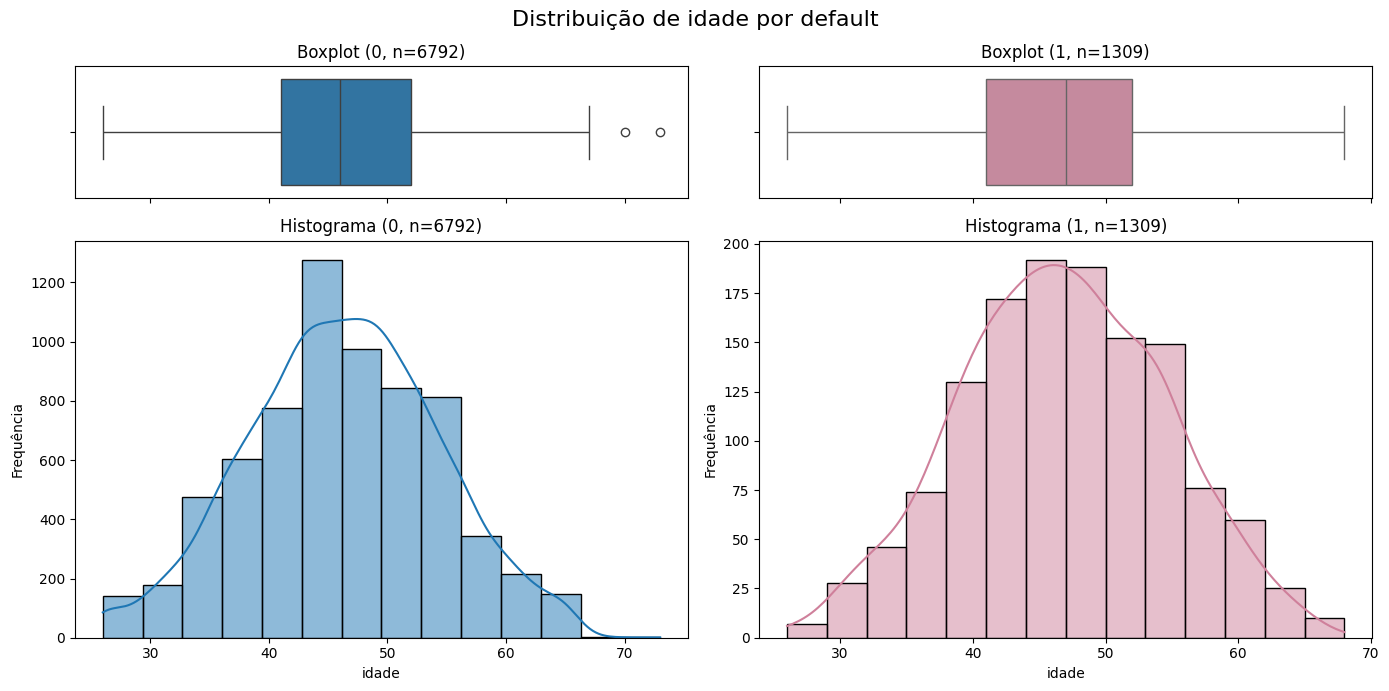

In [ ]:
# Distribuição das idades
plotar_distribuicao_agrupada(df_treino, 'idade')

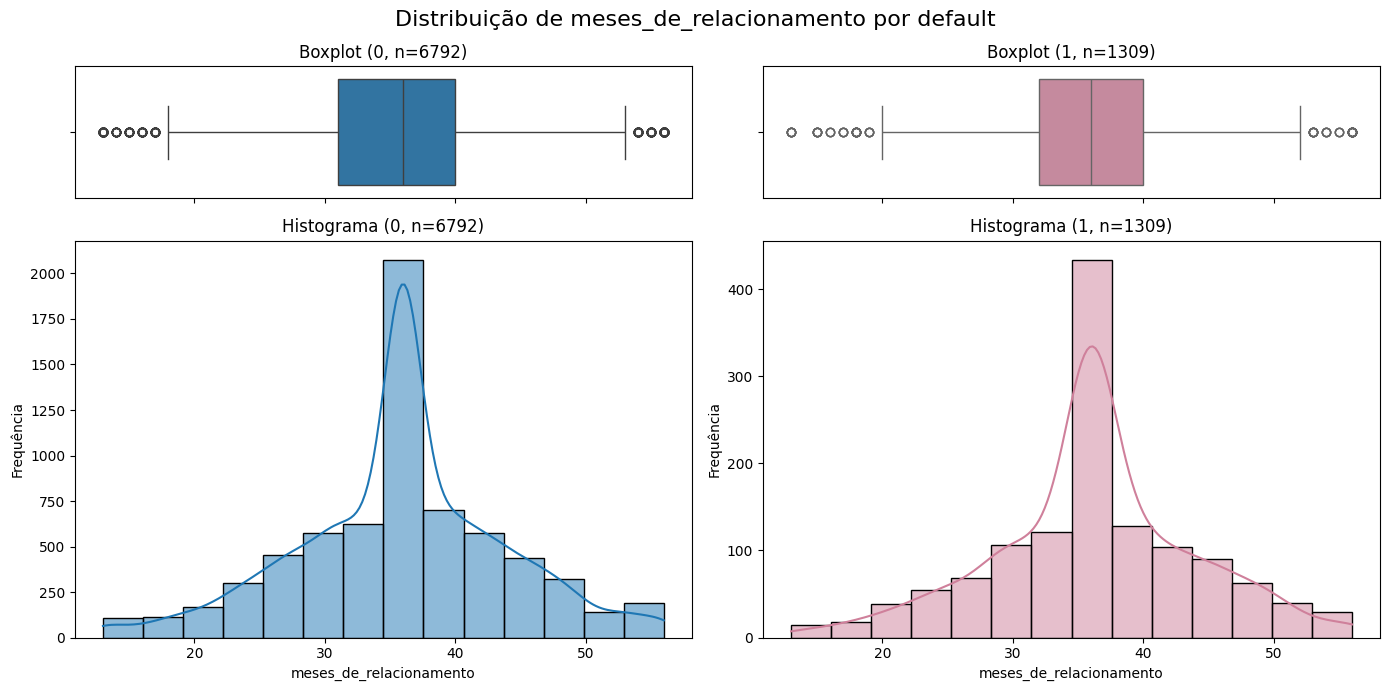

In [ ]:
# Distribuição do tempo de relacionamento com a instituição
plotar_distribuicao_agrupada(df_treino, 'meses_de_relacionamento')

> A distribuição da coluna `meses_de_relacionamento` tem um comportamento muito parecida entre adimplentes e inadimplentes

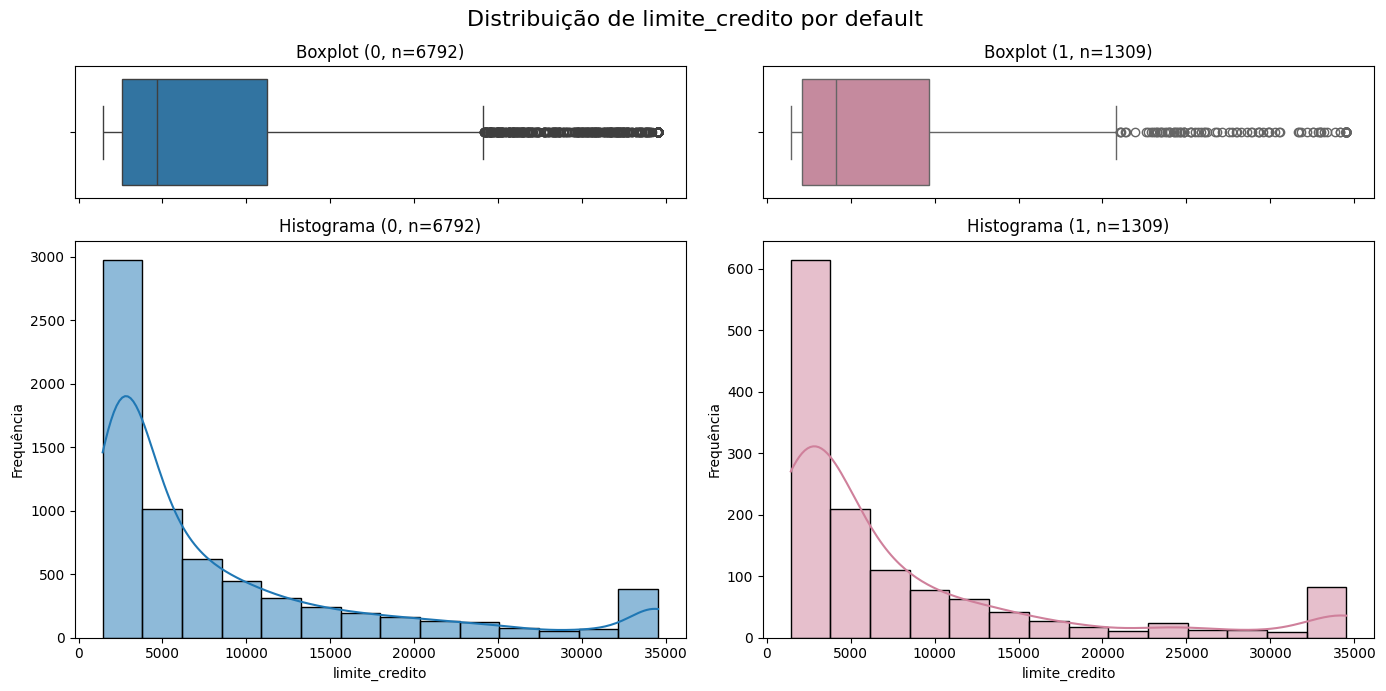

In [ ]:
# Distribuição do limite de crédito
plotar_distribuicao_agrupada(df_treino, 'limite_credito')

> A distribuição da coluna `limite_credito` também é muito parecida entre adimplentes e inadimplentes. Isso pode indicar que ela não seja uma boa variável para explicar a variável `target`

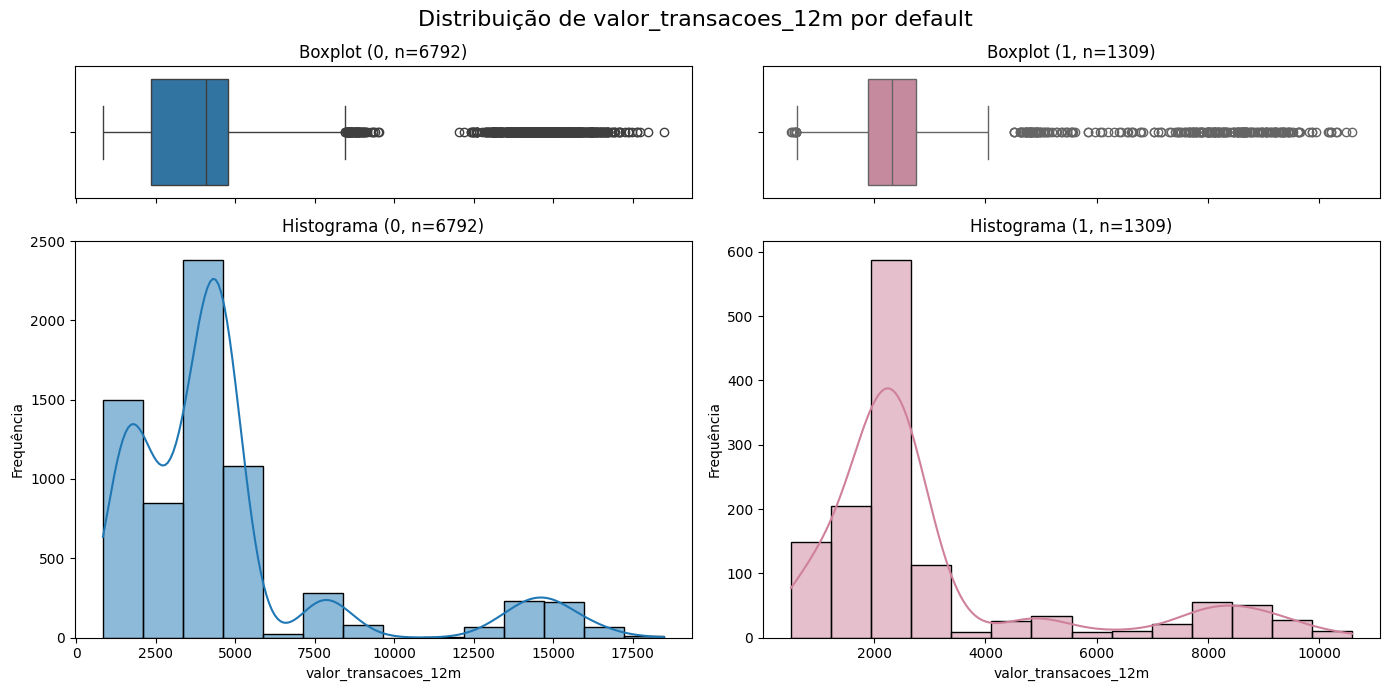

In [ ]:
# Distribuição do valor total das transações nos últimos 12 meses
plotar_distribuicao_agrupada(df_treino, 'valor_transacoes_12m')

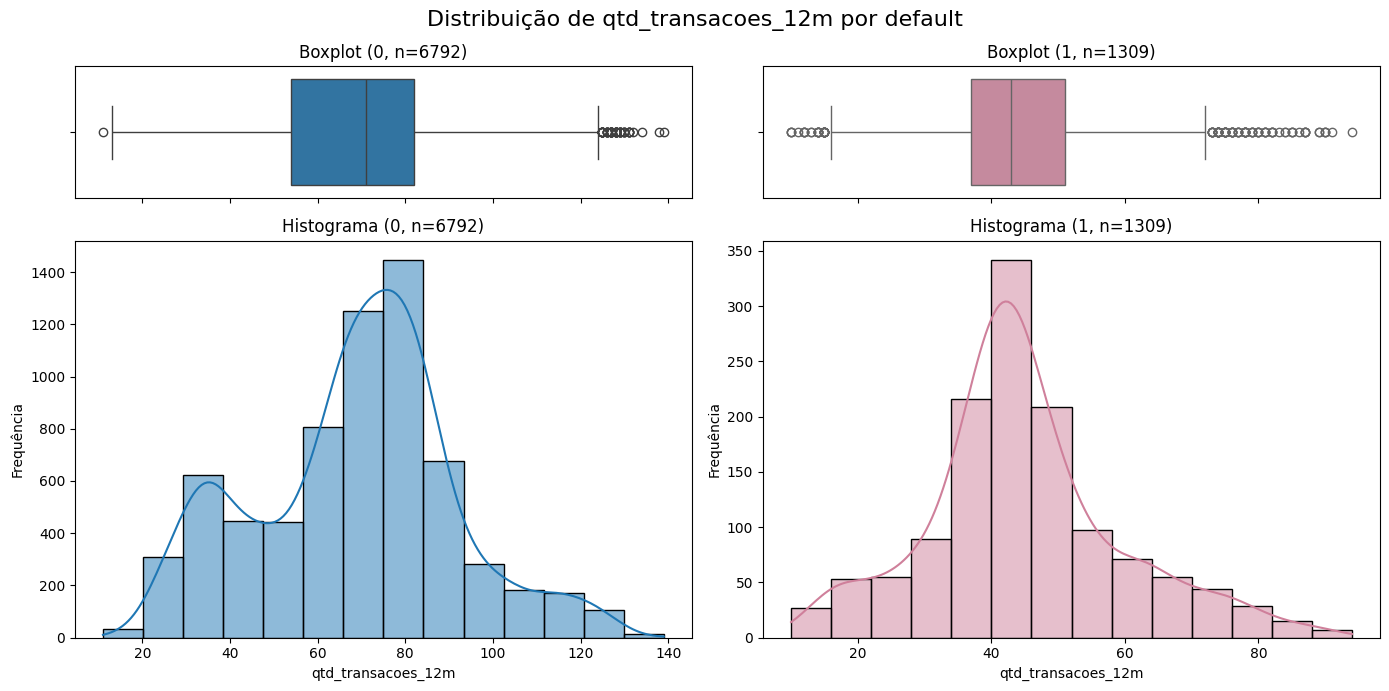

In [ ]:
# Distribuição do número de transações nos últimos 12 meses
plotar_distribuicao_agrupada(df_treino, 'qtd_transacoes_12m')

### Gráfico de colunas das variáveis categóricas

In [ ]:
def plotar_proporcao_categorica(dados, coluna_categoria, coluna_alvo='default',
                                paleta=['#1F77B4', '#CF809B'], ordenar_por=1, crescente=False):
    """
    Gera um gráfico de proporção com barras agrupadas para uma variável categórica,
    mostrando a distribuição do alvo por categorias e permite ordenar as categorias.

    Parâmetros:
    - dados: DataFrame contendo os dados.
    - coluna_categoria: Coluna categórica a ser analisada.
    - coluna_alvo: Coluna de agrupamento que define as proporções (exemplo: inadimplência).
    - paleta: Lista de cores para os grupos (padrão: ['#1f77b4', '#ff7f0e']).
    - ordenar_por: Valor da categoria da coluna_alvo a ser usado na ordenação (ex: 0 ou 1).
    - crescente: Se True, ordena as categorias em ordem crescente. Padrão: False (decrescente).
    """

    # Remover valores nulos para evitar erros na análise
    dados = dados[[coluna_categoria, coluna_alvo]].dropna()

    # Criar tabela de contagem e calcular proporções
    contagem_categorias = dados.groupby([coluna_categoria, coluna_alvo]).size().reset_index(name='Contagem')
    totais_categorias = dados.groupby(coluna_categoria).size().reset_index(name='Total')
    proporcoes = contagem_categorias.merge(totais_categorias, on=coluna_categoria)
    proporcoes['Proporcao'] = proporcoes['Contagem'] / proporcoes['Total']

    # Ordenação flexível
    if ordenar_por in dados[coluna_alvo].unique():
        ordem = (
            proporcoes[proporcoes[coluna_alvo] == ordenar_por]
            .sort_values(by='Proporcao', ascending=crescente)[coluna_categoria]
        )
        proporcoes[coluna_categoria] = pd.Categorical(proporcoes[coluna_categoria], categories=ordem, ordered=True)

    # Criar gráfico de barras
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(data=proporcoes, x=coluna_categoria, y='Proporcao', hue=coluna_alvo, palette=paleta)

    # Adicionar rótulos de porcentagem sobre as barras
    for barras in ax.containers:
        ax.bar_label(
            barras,
            fmt="%.2f%%",
            labels=[f"{v.get_height() * 100:.2f}%" for v in barras],
            label_type="edge",
            padding=3
        )

    # Ajustar limites do gráfico
    plt.ylim(0, proporcoes['Proporcao'].max() + 0.1)

    # Melhorando a apresentação do gráfico
    plt.title(f'Proporção de {coluna_alvo} por {coluna_categoria}')
    plt.xlabel(coluna_categoria)
    plt.ylabel('Proporção')
    plt.xticks(rotation=45)
    plt.legend(title=coluna_alvo)

    plt.show()

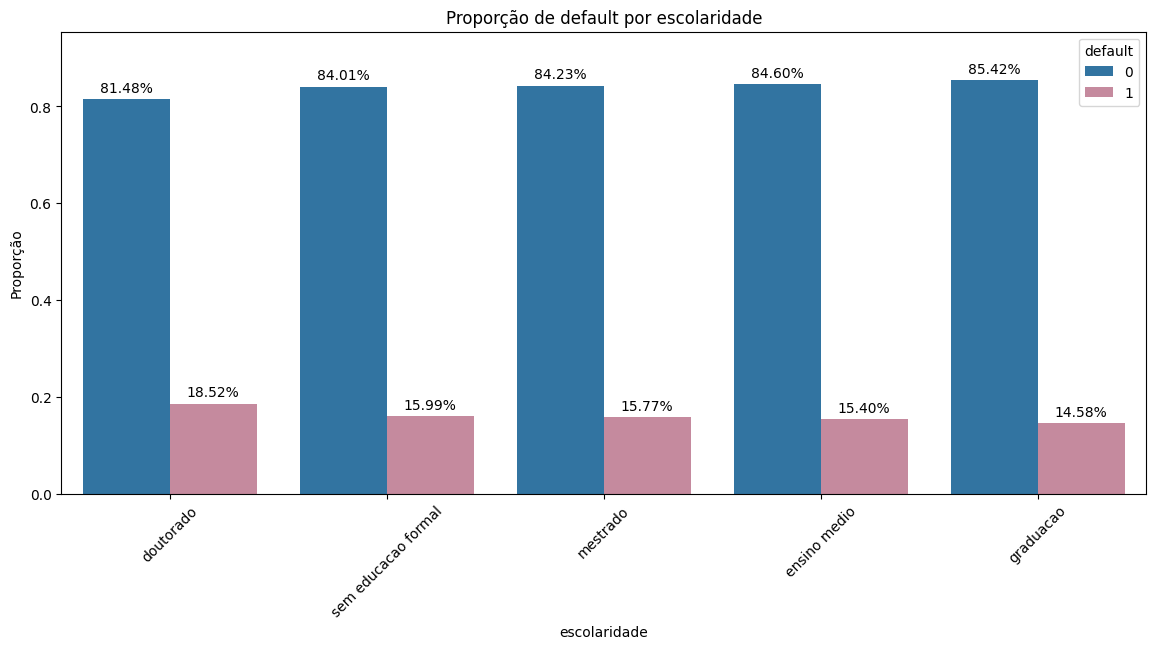

In [ ]:
# Proporções agrupadas por Escolaridade
plotar_proporcao_categorica(df_treino, 'escolaridade')

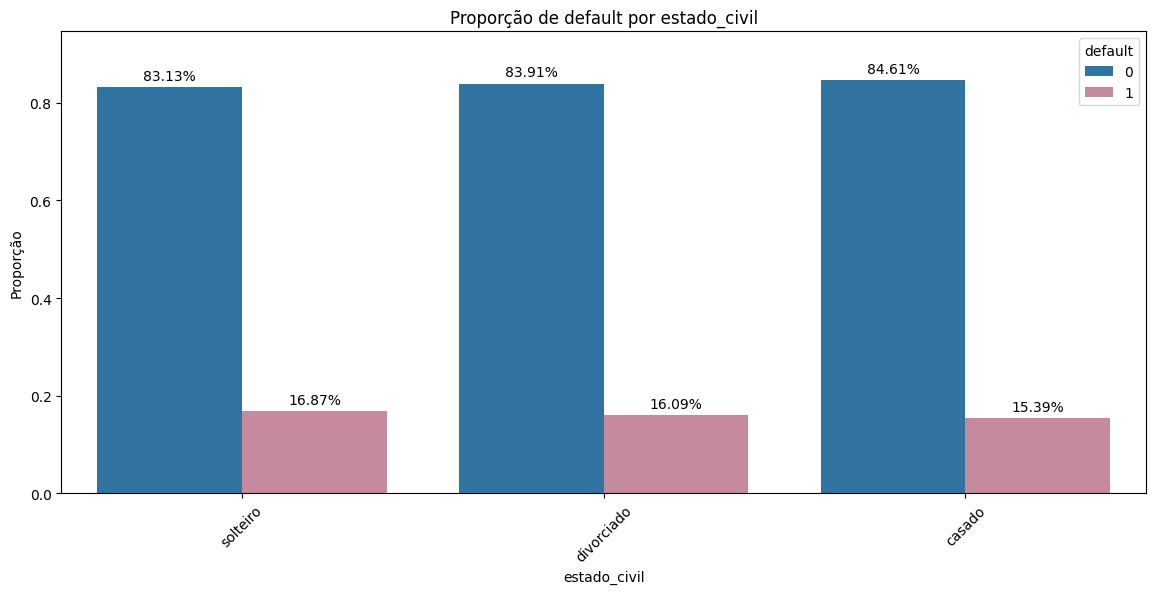

In [ ]:
# Proporções agrupadas por Estado Civil
plotar_proporcao_categorica(df_treino, 'estado_civil')

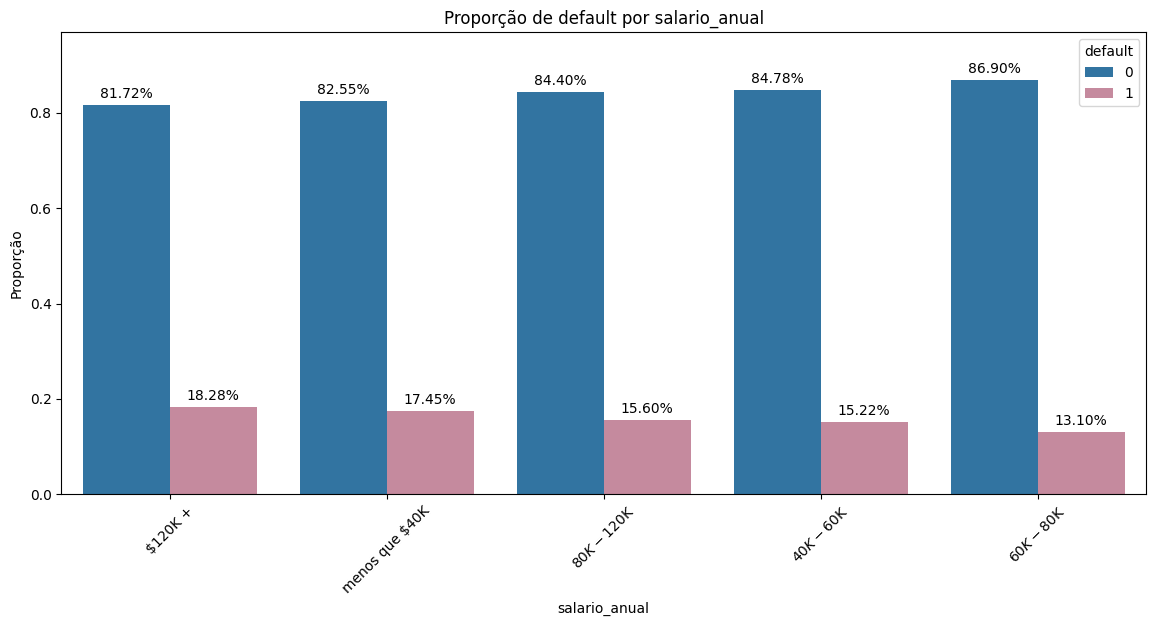

In [ ]:
# Proporções agrupadas por Faixa Salarial
plotar_proporcao_categorica(df_treino, 'salario_anual')

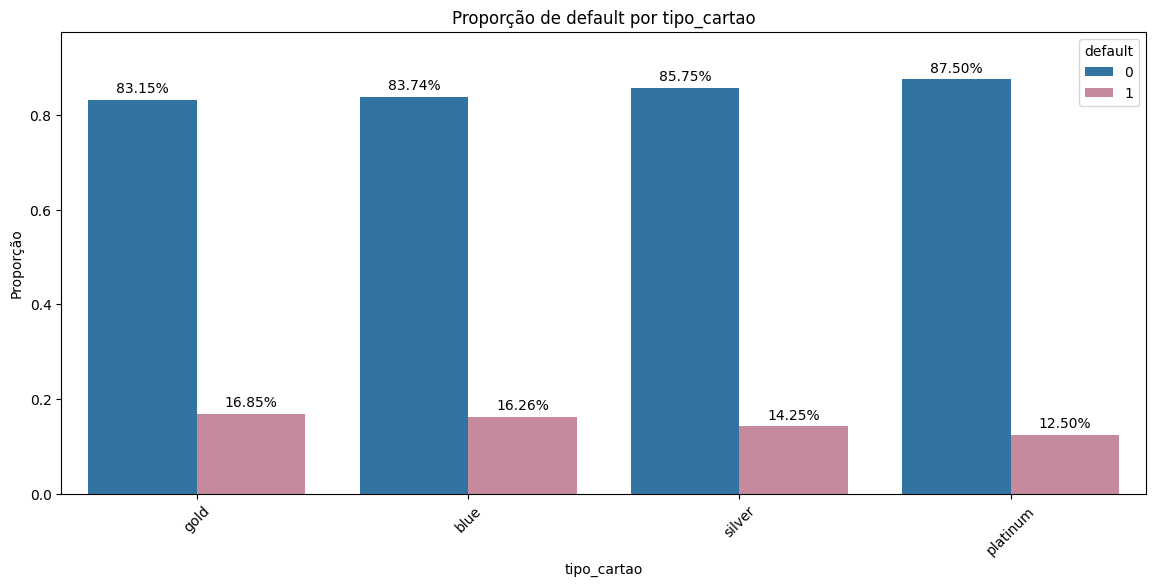

In [ ]:
# Proporções agrupadas por Tipo de Cartão
plotar_proporcao_categorica(df_treino, 'tipo_cartao')

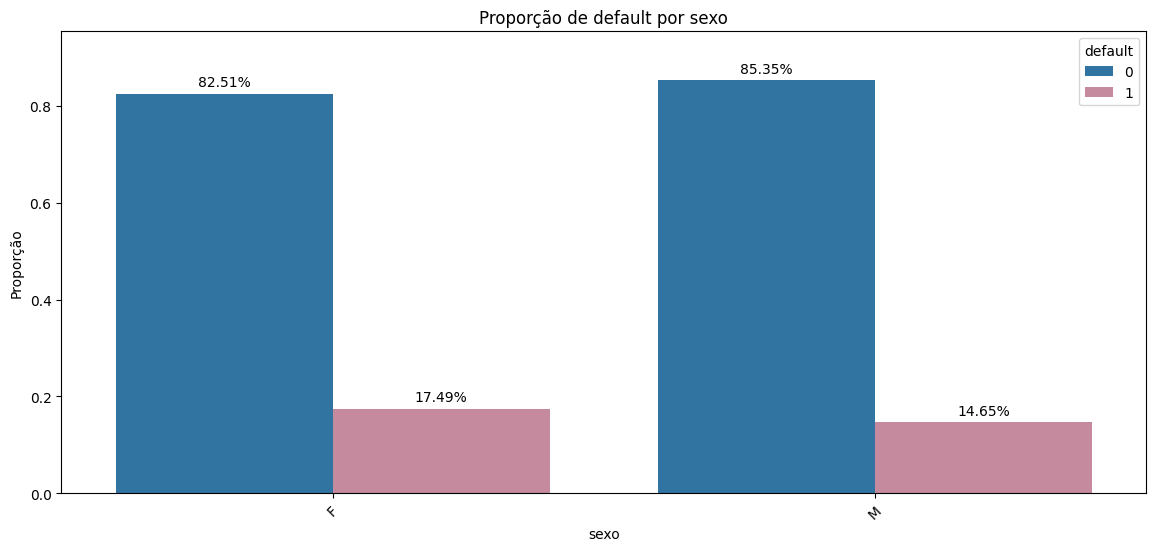

In [ ]:
# Proporções agrupadas por Gênero
plotar_proporcao_categorica(df_treino, 'sexo')

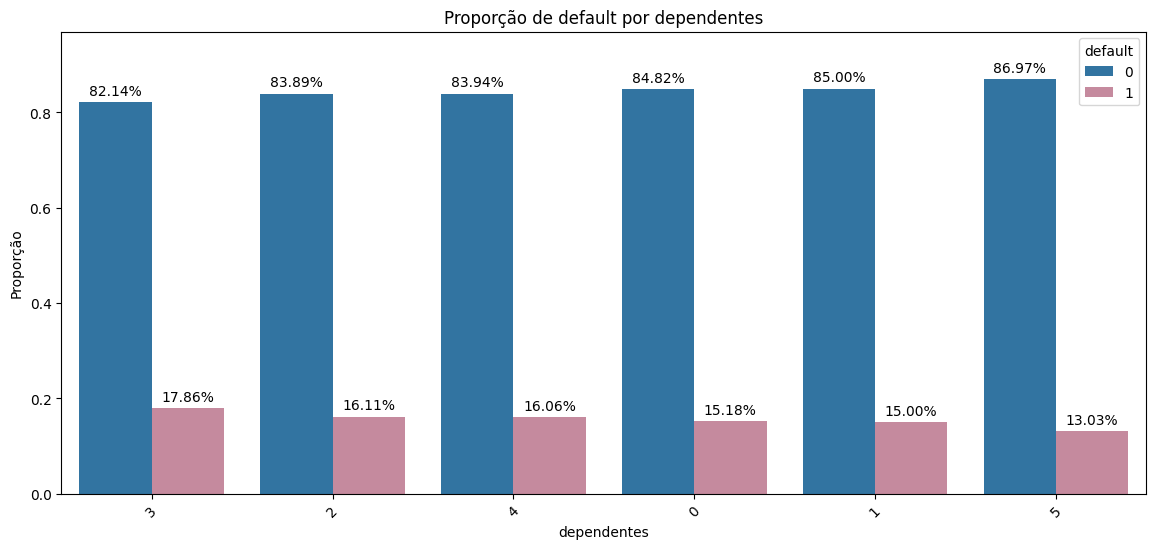

In [ ]:
# Proporções agrupadas por Número de Dependentes
plotar_proporcao_categorica(df_treino, 'dependentes')

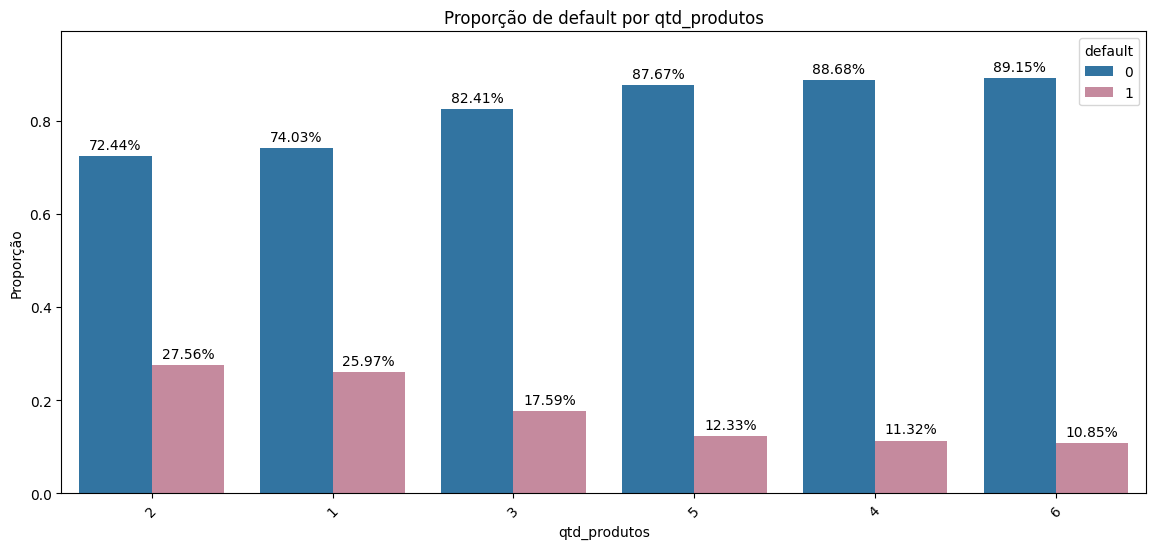

In [ ]:
# Proporções agrupadas por Quantidade de Produtos
plotar_proporcao_categorica(df_treino, 'qtd_produtos')

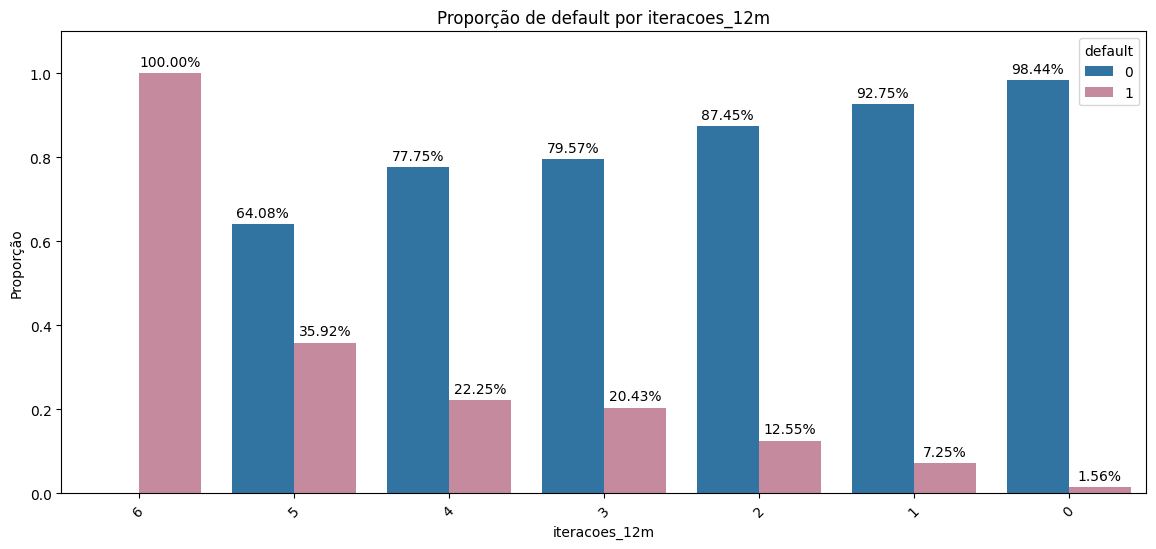

In [ ]:
# Proporções agrupadas por Número de Interações nos últimos 12 meses
plotar_proporcao_categorica(df_treino, 'iteracoes_12m')

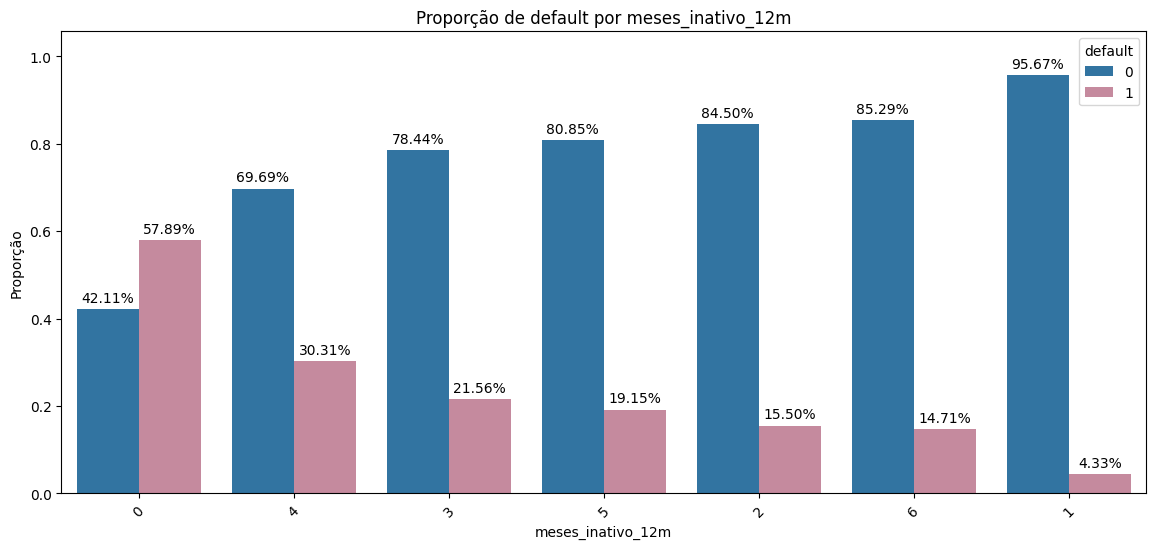

In [ ]:
# Proporções agrupadas por Meses Inativo nos últimos 12 meses
plotar_proporcao_categorica(df_treino, 'meses_inativo_12m')

## Análises multivariadas

In [ ]:
def grafico_dispersao(dados, x_col, y_col, hue_col='tipo_cartao'):
    """
    Plota um gráfico de dispersão entre duas variáveis, com hue definido por 'salario_anual'.

    Parâmetros:
    - dados: DataFrame contendo os dados.
    - x_col: Nome da coluna para o eixo X.
    - y_col: Nome da coluna para o eixo Y.
    - hue_col: Coluna categórica para diferenciação das cores (padrão: 'salario_anual').
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=dados, x=x_col, y=y_col, hue=hue_col, palette='cividis', alpha=0.7)
    plt.title(f'Gráfico de Dispersão: {x_col} vs {y_col}', fontsize=14)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend(title=hue_col, bbox_to_anchor=(1, 1))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

1️⃣ Limite de Crédito vs. Valor Total das Transações
- Hipótese: Clientes com maior limite de crédito realizam transações de maior valor?

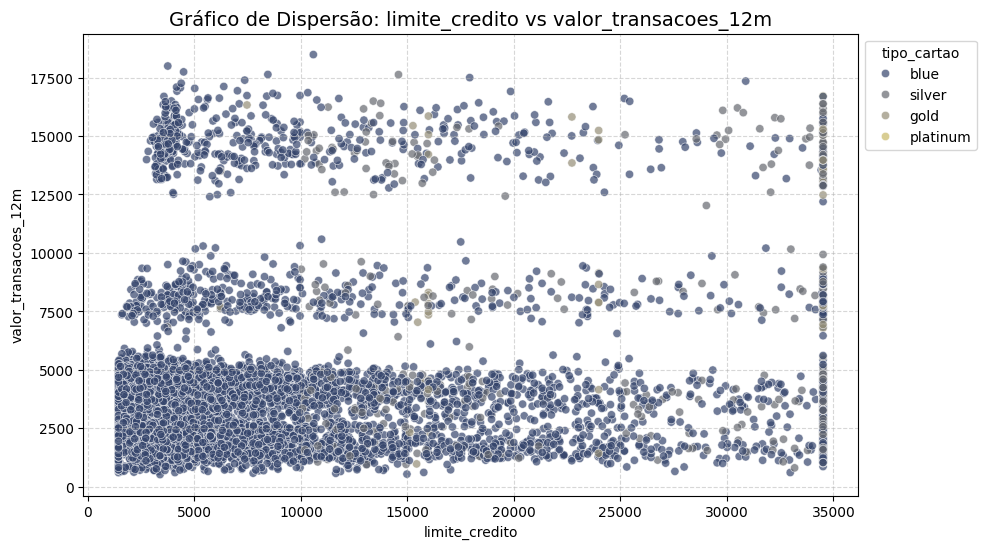

In [ ]:
grafico_dispersao(df_treino, 'limite_credito', 'valor_transacoes_12m')

2️⃣ Limite de Crédito vs. Quantidade de Transações
- Hipótese: Quanto maior o limite de crédito, mais transações são realizadas?

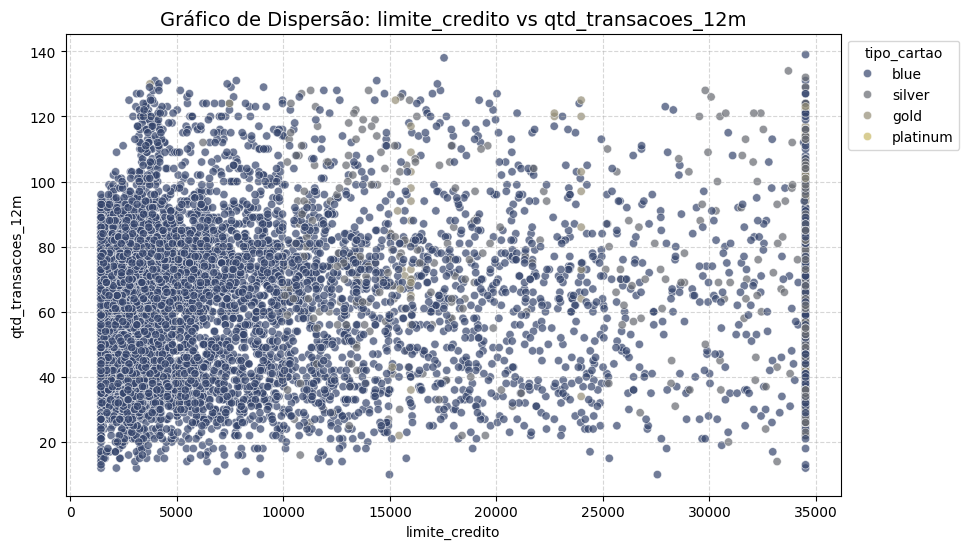

In [ ]:
grafico_dispersao(df_treino, 'limite_credito', 'qtd_transacoes_12m')

3️⃣ Valor Total das Transações vs. Quantidade de Transações
- Hipótese: Existe um padrão de gastos entre os clientes que fazem mais ou menos transações?

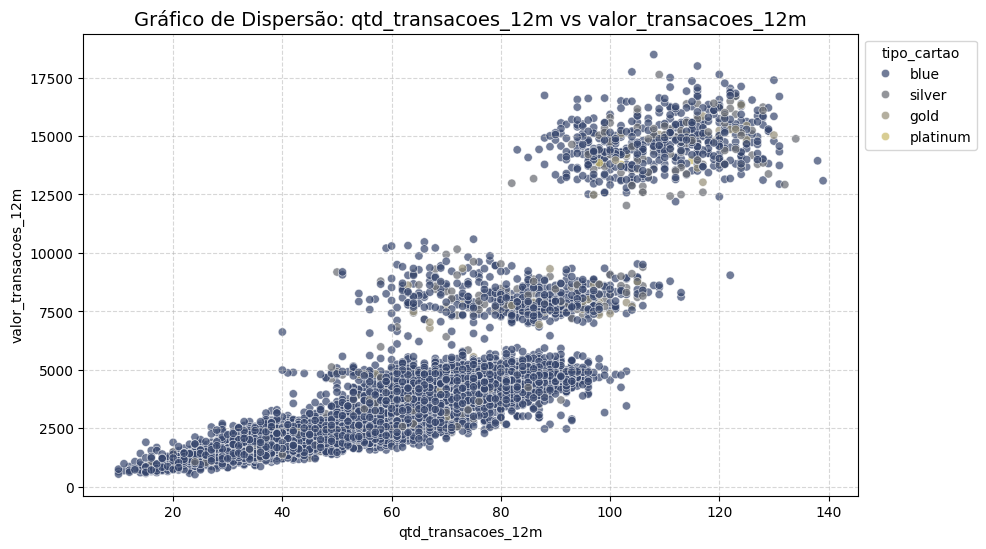

In [ ]:
grafico_dispersao(df_treino, 'qtd_transacoes_12m', 'valor_transacoes_12m')

> Há uma correlação forte entre a `quantidade` e o `valor` de transações nos últimos 12 meses

## Pré-processamento de Dados (Somente no Treino)

Imputação de valores ausentes, transformação de variáveis categóricas e normalização somente na base de treino.

In [ ]:
from sklearn.preprocessing import LabelEncoder

def preprocessar_dados(dados):
    """
    Prepara os dados para modelagem:
    - Imputa valores ausentes (somente na base de treino).
    - Codifica variáveis categóricas.

    Parâmetros:
    - dados: DataFrame de treino.

    Retorna:
    - DataFrame transformado.
    """
    dados = dados.copy()

    # Imputação de valores ausentes apenas na base de treino
    for col in dados.select_dtypes(include=['object']).columns:
        dados[col].fillna(dados[col].mode()[0], inplace=True)  # Preenchendo com a moda

    # Transformação de variáveis categóricas
    label_encoder = LabelEncoder()
    for col in ['sexo']:  # Apenas colunas binárias
        dados[col] = label_encoder.fit_transform(dados[col])

    dados = pd.get_dummies(dados, drop_first=True, dtype=int)

    return dados

# Aplicar transformação no Treino
df_treino_transf = preprocessar_dados(df_treino)

<ipython-input-32-702a86116fd1>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados[col].fillna(dados[col].mode()[0], inplace=True)  # Preenchendo com a moda


In [ ]:
# Primeiras linhas do DataFrame de treino pré-processado
df_treino_transf.head()

,idade,sexo,dependentes,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,...,escolaridade_sem educacao formal,estado_civil_divorciado,estado_civil_solteiro,salario_anual_$40K - $60K,salario_anual_$60K - $80K,salario_anual_$80K - $120K,salario_anual_menos que $40K,tipo_cartao_gold,tipo_cartao_platinum,tipo_cartao_silver
1795,57,1,4,36,5,4,3,7558.56,3676.81,67,...,0,0,1,0,0,1,0,0,0,0
3536,63,1,1,51,5,2,3,6102.92,4527.47,67,...,0,0,1,0,0,0,1,0,0,0
6236,43,0,3,26,6,2,2,2256.63,4893.93,76,...,0,0,1,0,0,0,1,0,0,0
3116,52,1,2,44,4,2,2,6617.13,3595.18,68,...,0,0,1,0,0,0,0,0,0,0
4464,54,0,3,45,5,4,1,3062.46,4037.22,71,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
# Verificando valores ausentes após aplicação
df_treino_transf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8101 entries, 1795 to 5957
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   idade                             8101 non-null   int64  
 1   sexo                              8101 non-null   int64  
 2   dependentes                       8101 non-null   int64  
 3   meses_de_relacionamento           8101 non-null   int64  
 4   qtd_produtos                      8101 non-null   int64  
 5   iteracoes_12m                     8101 non-null   int64  
 6   meses_inativo_12m                 8101 non-null   int64  
 7   limite_credito                    8101 non-null   float64
 8   valor_transacoes_12m              8101 non-null   float64
 9   qtd_transacoes_12m                8101 non-null   int64  
 10  default                           8101 non-null   int64  
 11  escolaridade_ensino medio         8101 non-null   int64  
 12  escolari

### Aplicação das Mesmas Transformações na Base de Teste

In [ ]:
def transformar_teste(df_teste, df_treino_transf):
    """
    Aplica as mesmas transformações da base de treino na base de teste.
    - Imputa valores ausentes com base nos valores do treino.
    - Aplica Label Encoding para colunas binárias.
    - Aplica One-Hot Encoding garantindo que todas as colunas do treino existam na base de teste.
    """
    df_teste = df_teste.copy()

    # Imputação de valores ausentes (usando a moda do treino para colunas categóricas)
    for col in df_teste.select_dtypes(include=['object']).columns:
        if col in df_treino_transf:  # Garantir que a coluna existe no treino antes de imputar
            df_teste[col] = df_teste[col].fillna(df_treino_transf[col].mode()[0])

    # Label Encoding para colunas binárias
    label_encoder = LabelEncoder()
    for col in ['sexo']:  # Ajustar conforme necessário
        if col in df_teste:  # Garantir que a coluna existe
            df_teste[col] = label_encoder.fit_transform(df_teste[col])

    # Aplicar One-Hot Encoding e garantir colunas iguais ao treino
    df_teste = pd.get_dummies(df_teste, drop_first=True, dtype=int)

    # Ajuste de colunas faltantes (se a base de treino tiver colunas extras que não existem na base de teste)
    missing_cols = set(df_treino_transf.columns) - set(df_teste.columns)
    for col in missing_cols:
        df_teste[col] = 0  # Adiciona colunas ausentes com 0 para manter a estrutura

    # Ajuste de colunas extras (caso a base de teste tenha colunas extras que não existem no treino)
    extra_cols = set(df_teste.columns) - set(df_treino_transf.columns)
    df_teste = df_teste.drop(columns=extra_cols)

    return df_teste

# Aplicar a função corrigida
df_teste_transf = transformar_teste(df_teste, df_treino_transf)

In [ ]:
df_teste_transf.head(2)

,idade,sexo,dependentes,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,...,escolaridade_sem educacao formal,estado_civil_divorciado,estado_civil_solteiro,salario_anual_$40K - $60K,salario_anual_$60K - $80K,salario_anual_$80K - $120K,salario_anual_menos que $40K,tipo_cartao_gold,tipo_cartao_platinum,tipo_cartao_silver
333,53,0,1,45,3,2,1,3471.41,1052.59,24,...,0,0,1,0,0,0,1,0,0,0
3356,60,1,1,42,4,4,3,28701.36,3516.32,57,...,0,0,1,0,1,0,0,0,0,1


In [ ]:
df_teste_transf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026 entries, 333 to 4427
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   idade                             2026 non-null   int64  
 1   sexo                              2026 non-null   int64  
 2   dependentes                       2026 non-null   int64  
 3   meses_de_relacionamento           2026 non-null   int64  
 4   qtd_produtos                      2026 non-null   int64  
 5   iteracoes_12m                     2026 non-null   int64  
 6   meses_inativo_12m                 2026 non-null   int64  
 7   limite_credito                    2026 non-null   float64
 8   valor_transacoes_12m              2026 non-null   float64
 9   qtd_transacoes_12m                2026 non-null   int64  
 10  default                           2026 non-null   int64  
 11  escolaridade_ensino medio         2026 non-null   int64  
 12  escolarid

## PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def analise_pca(dados, n_componentes=None):
    """
    Aplica PCA ao DataFrame e retorna os componentes principais,
    a variância explicada e a variância acumulada.

    Parâmetros:
    - dados: DataFrame contendo os dados numéricos.
    - n_componentes: Número de componentes principais desejados. Se None, detecta automaticamente.

    Retorna:
    - DataFrame com os componentes principais.
    - Lista com a variância explicada por cada componente.
    - Lista com a variância acumulada.
    - Objeto PCA treinado.
    """
    # Padronizar os dados
    scaler = StandardScaler()
    dados_escalados = scaler.fit_transform(dados)

    # Determinar número ideal de componentes se não for definido
    if n_componentes is None:
        pca_temp = PCA()
        pca_temp.fit(dados_escalados)
        variancia_acumulada = np.cumsum(pca_temp.explained_variance_ratio_)
        n_componentes = np.argmax(variancia_acumulada >= 0.95) + 1  # Número mínimo de componentes que explica 95% da variância

    # Aplicar PCA
    pca = PCA(n_components=n_componentes)
    componentes = pca.fit_transform(dados_escalados)

    # Criar DataFrame com os componentes principais
    colunas_pca = [f'PC{i+1}' for i in range(n_componentes)]
    df_pca = pd.DataFrame(data=componentes, columns=colunas_pca)

    # Variância explicada
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Gráfico de variância explicada acumulada
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_componentes + 1), cumulative_variance, marker='o', linestyle='--', label='Variância Acumulada')
    plt.bar(range(1, n_componentes + 1), explained_variance, alpha=0.5, label='Variância por Componente')
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% da Variância')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Variância Explicada')
    plt.title('Análise de Componentes Principais (PCA)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df_pca, explained_variance, cumulative_variance, pca

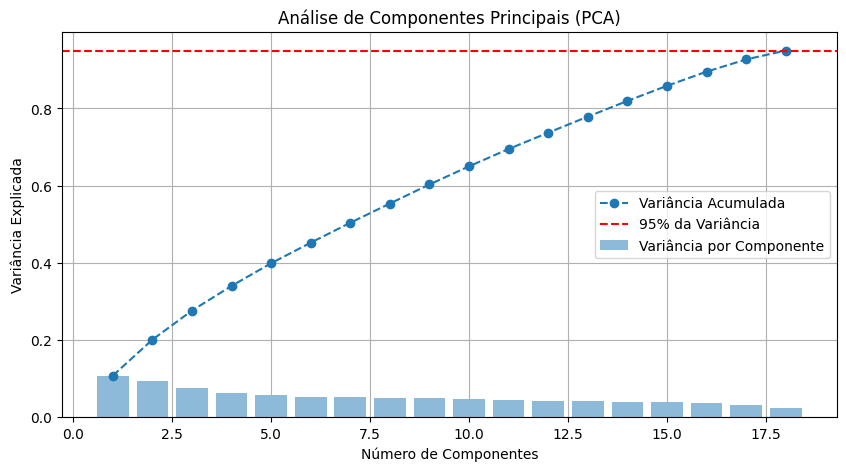

In [ ]:
# Aplicar PCA ao DataFrame pré-processado
df_pca_treino, explained_variance_treino, cumulative_variance_treino, modelo_pca_treino = analise_pca(df_treino_transf, n_componentes=None)

## Matriz de correlação

In [ ]:
def plot_matriz_correlacao(df, threshold=0.0):
    """
    Plota uma matriz de correlação aprimorada com melhor legibilidade.

    Parâmetros:
    - df: DataFrame com os dados numéricos.
    - threshold: Valor mínimo absoluto para exibir anotações (padrão 0.0 exibe todas as correlações).
    """
    # Criando a matriz de correlação
    matriz_correlacao = df.corr()

    # Criando uma máscara para esconder a parte superior do triângulo
    mask = np.triu(np.ones_like(matriz_correlacao, dtype=bool))

    # Criando a figura
    plt.figure(figsize=(16, 8))

    # Criando o heatmap
    ax = sns.heatmap(
        matriz_correlacao,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        linewidths=1,
        cbar_kws={'shrink': 0.75},  # Ajuste do tamanho da barra de cores
        annot_kws={"size": 10},  # Ajuste do tamanho das anotações
    )

    # Destacar correlações fortes (>0.7 ou <-0.7)
    for i in range(len(matriz_correlacao.columns)):
        for j in range(i):
            valor = matriz_correlacao.iloc[i, j]
            if abs(valor) > 0.7:  # Definir um limite para destacar correlações fortes
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))

    # Melhorias no título e labels
    plt.title("Mapa de Calor da Matriz de Correlação", fontsize=16)
    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.yticks(fontsize=12)

    plt.show()

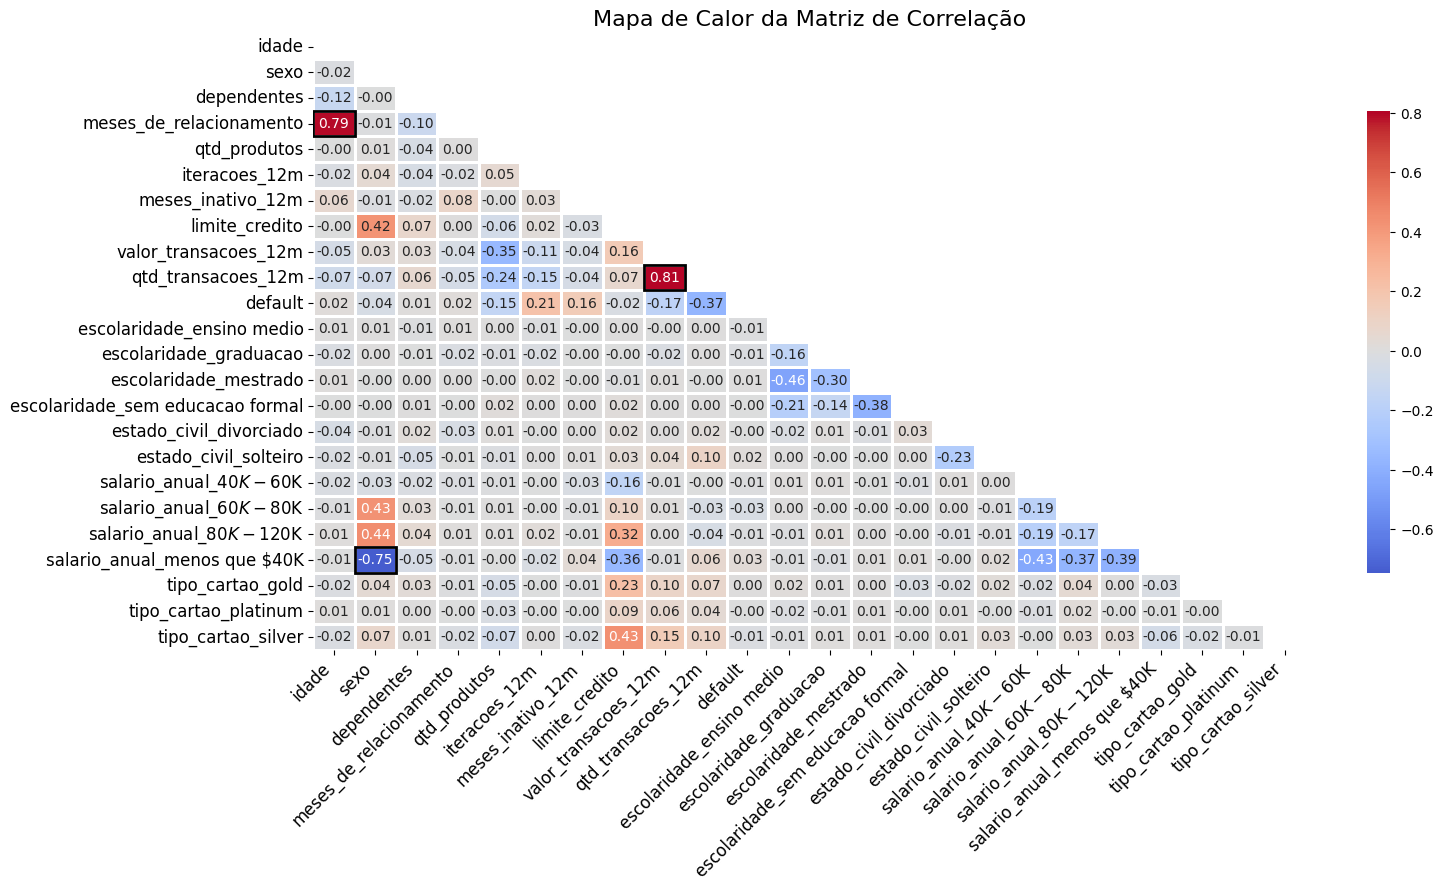

In [ ]:
# Gerar o gráfico com a matriz de correlação aprimorada
plot_matriz_correlacao(df_treino_transf)

## Verificando todos os dados de treino e teste

In [ ]:
# Definir variáveis X e y
X_treino = df_treino_transf.drop(columns=['default'])
y_treino = df_treino_transf['default']

X_teste = df_teste_transf.drop(columns=['default'])
y_teste = df_teste_transf['default']

In [ ]:
# Variáveis explicativas do treino
X_treino.head(2)

,idade,sexo,dependentes,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,...,escolaridade_sem educacao formal,estado_civil_divorciado,estado_civil_solteiro,salario_anual_$40K - $60K,salario_anual_$60K - $80K,salario_anual_$80K - $120K,salario_anual_menos que $40K,tipo_cartao_gold,tipo_cartao_platinum,tipo_cartao_silver
1795,57,1,4,36,5,4,3,7558.56,3676.81,67,...,0,0,1,0,0,1,0,0,0,0
3536,63,1,1,51,5,2,3,6102.92,4527.47,67,...,0,0,1,0,0,0,1,0,0,0


In [ ]:
# Variável resposta do treino
y_treino.head(2)

,default
1795,0
3536,0


In [ ]:
# Variáveis explicativas do teste
X_teste.head(2)

,idade,sexo,dependentes,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m,...,escolaridade_sem educacao formal,estado_civil_divorciado,estado_civil_solteiro,salario_anual_$40K - $60K,salario_anual_$60K - $80K,salario_anual_$80K - $120K,salario_anual_menos que $40K,tipo_cartao_gold,tipo_cartao_platinum,tipo_cartao_silver
333,53,0,1,45,3,2,1,3471.41,1052.59,24,...,0,0,1,0,0,0,1,0,0,0
3356,60,1,1,42,4,4,3,28701.36,3516.32,57,...,0,0,1,0,1,0,0,0,0,1


In [ ]:
# Variável resposta do teste
y_teste.head(2)

,default
333,0
3356,0
